# 2. Classification in the CIFAR-10 dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing  # Import preprocessing correctly
from keras.datasets import cifar10
import cv2

##2.1 Split data

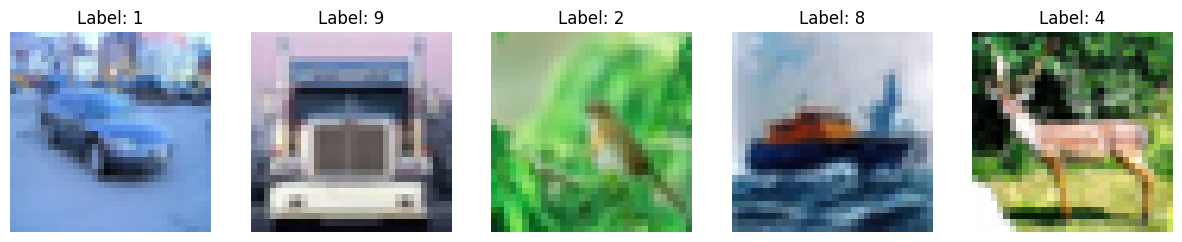

Tamaño del conjunto de entrenamiento: (48000, 32, 32, 3)
Tamaño del conjunto de validación: (6000, 32, 32, 3)
Tamaño del conjunto de prueba: (6000, 32, 32, 3)


In [ ]:
(im_train_and_val, y_train_and_val), (im_test, y_test) = cifar10.load_data()

np.random.seed(42)

# Unir el conjunto de datos de entrenamiento y prueba para dividir todo nuevamente
images = np.concatenate((im_train_and_val, im_test), axis=0)
labels = np.concatenate((y_train_and_val, y_test), axis=0)

# Definir el tamaño del conjunto
n_total = images.shape[0]
n_train = int(n_total * 0.80)  # 80% para entrenamiento
n_val = int(n_total * 0.10)    # 10% para validación
n_test = n_total - n_train - n_val

# Mezclar los datos de forma aleatoria
indices = np.random.permutation(n_total)
train_idx, val_idx, test_idx = indices[:n_train], indices[n_train:n_train+n_val], indices[n_train+n_val:]

# Crear los conjuntos de entrenamiento, validación y prueba
x_train, y_train = images[train_idx], labels[train_idx]
x_val, y_val = images[val_idx], labels[val_idx]
x_test, y_test = images[test_idx], labels[test_idx]

# Mostrar algunas imágenes del conjunto de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f'Label: {y_train[i][0]}')
    ax.axis('off')
plt.show()

# Mostrar el tamaño de cada conjunto
print(f'Tamaño del conjunto de entrenamiento: {x_train.shape}')
print(f'Tamaño del conjunto de validación: {x_val.shape}')
print(f'Tamaño del conjunto de prueba: {x_test.shape}')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Aplanar las imágenes de 32x32x3
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalizar los datos (escalar los valores de píxeles de 0-255 a un rango de 0-1)
scaler = StandardScaler()
x_train_flat_scaled = scaler.fit_transform(x_train_flat)
x_val_flat_scaled = scaler.transform(x_val_flat)
x_test_flat_scaled = scaler.transform(x_test_flat)

# Aplicar PCA
# Según cantidad de varianza explicada (95%)
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_flat_scaled)
x_val_pca = pca.transform(x_val_flat_scaled)
x_test_pca = pca.transform(x_test_flat_scaled)

# Mostrar la cantidad de componentes principales seleccionados
print(f"Componentes principales seleccionados: {pca.n_components_}")


Componentes principales seleccionados: 221


In [ ]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print(f'Tamaño del conjunto de validación: {x_train_flat.shape}')
print(f'Tamaño del conjunto de entrenamiento: {x_train_pca.shape}')
print(f'Tamaño del Test de prueba: {y_train.shape}')


Tamaño del conjunto de validación: (48000, 3072)
Tamaño del conjunto de entrenamiento: (48000, 221)
Tamaño del Test de prueba: (48000,)


### 2.1.1 Clasificación imágenes

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_val, y_val_pred, title, verbose=True):
  conf_matrix = confusion_matrix(y_val, y_val_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
  plt.title(f'Matriz de Confusión - {title}')
  plt.ylabel('Etiqueta verdadera')
  plt.xlabel('Etiqueta predicha')
  plt.show()

def train_model(model, title, x_train, y_train, x_val, y_val, verbose=True, plot=True):
  model.fit(x_train, y_train)
  y_val_pred = model.predict(x_val)

  # Evaluar la precisión en el conjunto de validación
  val_acc = accuracy_score(y_val, y_val_pred)
  if verbose:
    print(f'Precisión en validación ({title}): {val_acc:.4f}')
    plot_confusion_matrix(y_val, y_val_pred, title, verbose=plot)
  return val_acc, model

### Logistic Regression

Precisión en validación (Logistic Regression): 0.4113


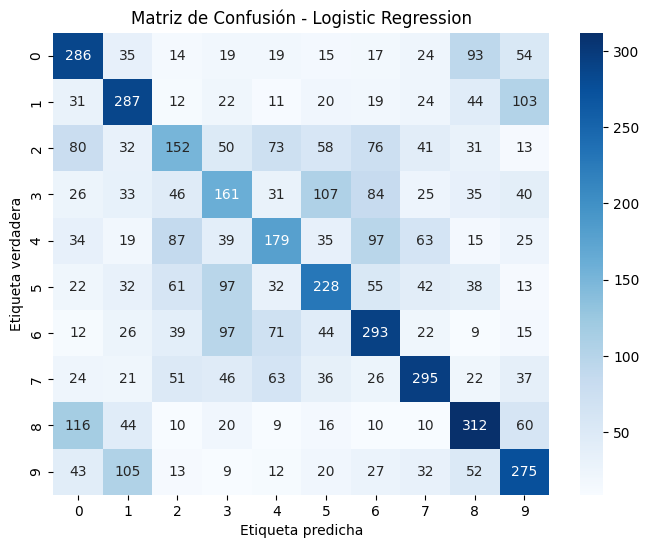

0.41133333333333333

In [ ]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
train_model(log_reg, 'Logistic Regression', x_train_pca, y_train, x_val_pca, y_val)

### SVC

Precisión en validación (SVM): 0.3660


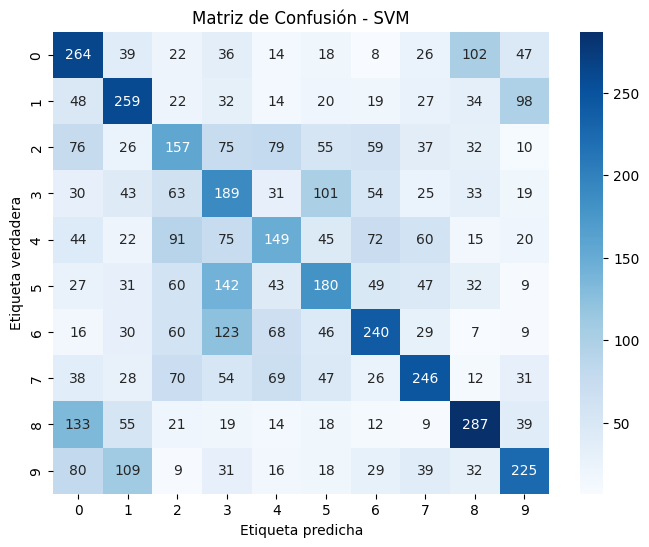

0.366

In [ ]:
from sklearn.svm import SVC

x_train_small = x_train_pca[:10000]
y_train_small = y_train[:10000]

# Crear el modelo SVM
svm_model = SVC(kernel='linear')
train_model(svm_model, 'SVM', x_train_small, y_train_small, x_val_pca, y_val)

Precisión en validación (SVM (rbf)): 0.5378


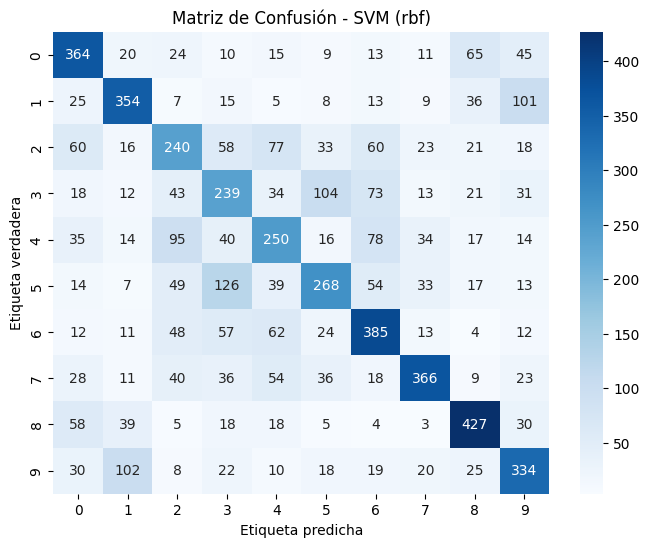

In [ ]:
from sklearn.svm import SVC

# Crear el modelo SVM
svm_model_rbf_pca = SVC(kernel='rbf')
acc, svm_model_rbf_pca = train_model(svm_model_rbf_pca, 'SVM (rbf)', x_train_pca, y_train, x_val_pca, y_val)

### KNN

Precisión en validación (KNN): 0.3708


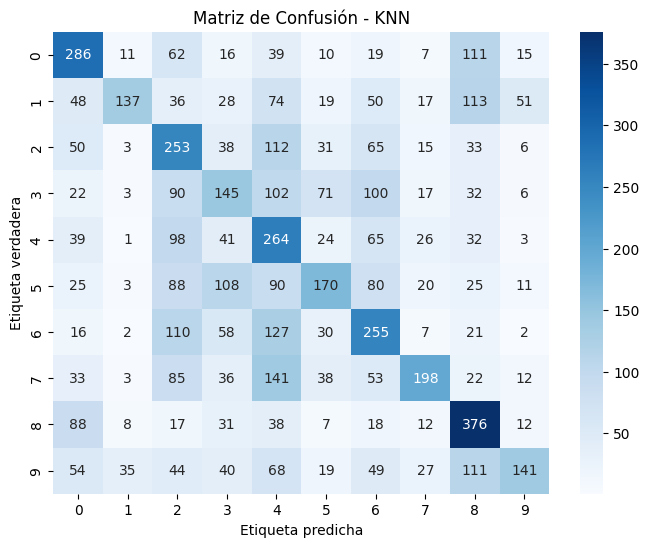

0.37083333333333335

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1)
train_model(knn_model, 'KNN', x_train_pca, y_train, x_val_pca, y_val)

### Decision Trees

Precisión en validación (Decision Tree Classifier): 0.2525


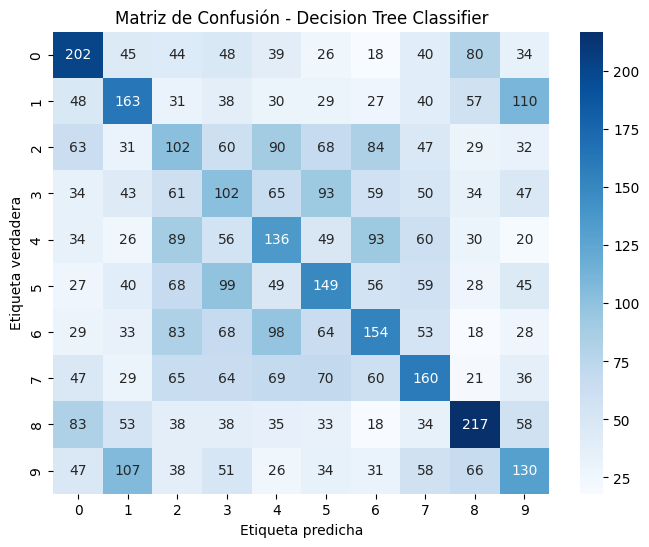

0.2525

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
train_model(tree_model, 'Decision Tree Classifier', x_train_pca, y_train, x_val_pca, y_val)

### Naive Bayes

Precisión en validación (Naive Bayes): 0.3077


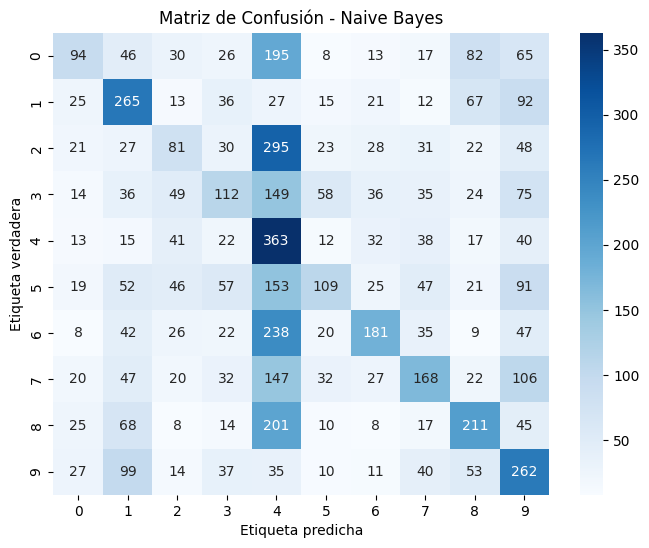

0.30766666666666664

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
train_model(nb_model, 'Naive Bayes', x_train_pca, y_train, x_val_pca, y_val)

## 2.2 Clasificación usando GIST

In [ ]:
# This class implements the extraction of a GIST descriptor from an image.
# The GIST descriptor was originally proposed in https://people.csail.mit.edu/torralba/code/spatialenvelope/
# This code was taken from https://github.com/imoken1122/GIST-feature-extractor, on september 2020

import numpy as np
import numpy.matlib as nm
import numpy.fft as f
from PIL import Image

class GIST():
    def __init__(self,param):
        self.param = param

    def _createGabor(self,orr,n):

        gabor_param = []
        Nscalse = len(orr)
        Nfilters = sum(orr)
        if len(n) == 1:
            n = [n[0],n[0]]
        for i in range(Nscalse):
            for j in range(orr[i]):
                gabor_param.append([.35,.3/(1.85**(i)),16*orr[i]**2/32**2, np.pi/(orr[i])*(j)])
        gabor_param = np.array(gabor_param)
        fx, fy = np.meshgrid(np.arange(-n[1]/2,n[1]/2-1 + 1), np.arange(-n[0]/2, n[0]/2-1 + 1))
        fr = f.fftshift(np.sqrt(fx**2+fy**2))
        t = f.fftshift(np.angle(fx+ 1j*fy))

        G = np.zeros([n[0],n[1],Nfilters])
        for i in range(Nfilters):
            tr = t + gabor_param[i,3]
            tr+= 2*np.pi*(tr < -np.pi) - 2 * np.pi*(tr>np.pi)
            G[:,:,i] = np.exp(-10*gabor_param[i,0]*(fr/n[1]/gabor_param[i,1]-1)**2-2*gabor_param[i,2]*np.pi*tr**2)

        return G

    def _more_config(self,img):

        self.param["imageSize"] = [img.shape[0], img.shape[1]]
        self.param["G"] = self._createGabor(self.param["orientationsPerScale"],np.array(self.param["imageSize"])+2*self.param["boundaryExtension"])


    def _preprocess(self,img):
        M = self.param["imageSize"]
        if len(M) == 1:
            M = [M, M]
        scale = np.max([M[0]/img.shape[0], M[1]/img.shape[1]])
        newsize = list(map(int,np.round(np.array([img.shape[1],img.shape[0]]) * scale)))
        img = np.array(Image.fromarray(img).resize(newsize, Image.BILINEAR))
        #img = imresize(img,newsize,'bilinear')

        nr,nc = img.shape
        sr = (nr-M[0])/2
        sc = (nc-M[1])/2

        img = img[int(sr):int(sr+M[0])+ 1,int(sc):int(sc+M[1])+1]
        img = img- np.min(img)
        if np.sum(img) != 0:
            img = 255*(img/np.max(img))

        return img


    def _prefilt(self,img):

        w = 5
        fc=self.param["fc_prefilt"]
        s1 = fc/np.sqrt(np.log(2))
        img=np.log(img +1 )
        img = np.pad(img,[w,w],"symmetric")

        sn,sm = img.shape
        n = np.max([sn,sm])
        n += n%2

        if sn == sm:
            img = np.pad(img,[0,int(n-sn)],"symmetric")
        else:
            img = np.pad(img,[0,int(n-sn)], "symmetric")[:,:sm]

        fx,fy = np.meshgrid(np.arange(-n/2,n/2-1 + 1),np.arange(-n/2,n/2-1 + 1))
        gf = f.fftshift((np.exp(-(fx**2+fy**2)/(s1**2))))
        gf = nm.repmat(gf,1,1)
        output = img - np.real(f.ifft2(f.fft2(img)*gf))

        localstd = nm.repmat(np.sqrt(abs(f.ifft2(f.fft2(output**2)*gf))), 1 ,1 )
        output = output/(0.2+localstd)
        output = output[w:sn-w, w:sm-w]
        return output

    def _gistGabor(self,img):

        w = self.param["numberBlocks"]
        G = self.param["G"]
        be = self.param["boundaryExtension"]
        ny,nx,Nfilters = G.shape
        W = w[0] * w[1]
        N = 1
        g = np.zeros((W*Nfilters, N))
        img = np.pad(img,[be,be],"symmetric")
        img = f.fft2(img)

        k = 0
        for n in range(Nfilters):
            ig = abs(f.ifft2(img*nm.repmat(G[:,:,n],1,1)))
            ig = ig[be:ny-be,be:nx-be]
            v = self._downN(ig,w)
            g[k:k+W,0] = v.reshape([W,N],order = "F").flatten()
            k += W
        return np.array(g)

    def _downN(self,x,N):
        nx = list(map(int,np.floor(np.linspace(0,x.shape[0],N[0]+1))))
        ny = list(map(int,np.floor(np.linspace(0,x.shape[1],N[1]+1))))
        y  = np.zeros((N[0],N[1]))
        for xx in range(N[0]):
            for yy in range(N[1]):
                a = x[nx[xx]:nx[xx+1], ny[yy]:ny[yy+1]]
                v = np.mean(np.mean(a,0))
                y[xx,yy]=v
        return y

    def _gist_extract(self,img):

        self._more_config(img)

        img = self._preprocess(img)

        output = self._prefilt(img)

        gist = self._gistGabor(output)

        return gist.flatten()

### GIST example

Training set size: (50000, 32, 32, 3)
Training set size: (10000, 32, 32, 3)


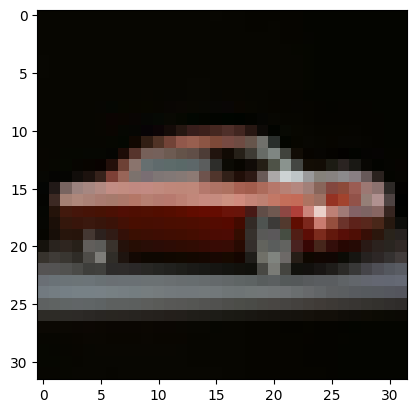

GIST descriptor: (256,)


In [ ]:
# get training data
(im_train_and_val, y_train_and_val), (im_test, y_test) = cifar10.load_data()
print('Training set size: {}'.format(im_train_and_val.shape))
print('Training set size: {}'.format(im_test.shape))

# Parameters needed for the GIST descriptor
param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract the GIST descriptor of image 134
mygist = GIST(param)
imggray = cv2.cvtColor(im_train_and_val[134,:,:,:], cv2.COLOR_BGR2GRAY)
plt.imshow(im_train_and_val[134,:,:,:])
plt.show()
gistdesc = np.squeeze(mygist._gist_extract(imggray))
print('GIST descriptor: {}'.format(gistdesc.shape))

In [ ]:
# Parameters needed for the GIST descriptor

param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Extract GIST descriptor of every image in the dataset
mygist = GIST(param)

n_train_and_val = im_train_and_val.shape[0]
n_test = im_test.shape[0]
x_train_and_val_gist = np.zeros((n_train_and_val,256))
x_test_gist = np.zeros((n_test,256))

for i in range(n_train_and_val):
  imggray = cv2.cvtColor(im_train_and_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_train_and_val_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))
  print('Converting training set, image ', i, ' out of ', n_train_and_val)

for i in range(n_test):
  imggray = cv2.cvtColor(im_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
  x_test_gist[i,:] = np.squeeze(mygist._gist_extract(imggray))
  print('Converting test set, image ', i, ' out of ', n_test)

Se han truncado las últimas 5000 líneas del flujo de salida.
Converting test set, image  5000  out of  10000
Converting test set, image  5001  out of  10000
Converting test set, image  5002  out of  10000
Converting test set, image  5003  out of  10000
Converting test set, image  5004  out of  10000
Converting test set, image  5005  out of  10000
Converting test set, image  5006  out of  10000
Converting test set, image  5007  out of  10000
Converting test set, image  5008  out of  10000
Converting test set, image  5009  out of  10000
Converting test set, image  5010  out of  10000
Converting test set, image  5011  out of  10000
Converting test set, image  5012  out of  10000
Converting test set, image  5013  out of  10000
Converting test set, image  5014  out of  10000
Converting test set, image  5015  out of  10000
Converting test set, image  5016  out of  10000
Converting test set, image  5017  out of  10000
Converting test set, image  5018  out of  10000
Converting test set, image 

### Split Data GIST

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


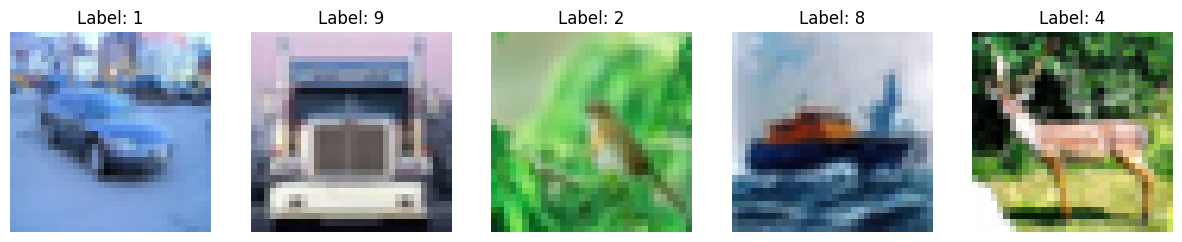

Tamaño del conjunto de entrenamiento: (48000, 32, 32, 3)
Tamaño del conjunto de validación: (6000, 32, 32, 3)
Tamaño del conjunto de prueba: (6000, 32, 32, 3)


In [ ]:
(im_train_and_val, y_train_and_val), (im_test, y_test) = cifar10.load_data()

np.random.seed(42)

# Unir el conjunto de datos de entrenamiento y prueba para dividir todo nuevamente
images = np.concatenate((im_train_and_val, im_test), axis=0)
labels = np.concatenate((y_train_and_val, y_test), axis=0)

# Definir el tamaño del conjunto
n_total = images.shape[0]
n_train = int(n_total * 0.80)  # 80% para entrenamiento
n_val = int(n_total * 0.10)    # 10% para validación
n_test = n_total - n_train - n_val   # 10% para validación

# Mezclar los datos de forma aleatoria
indices = np.random.permutation(n_total)
train_idx, val_idx, test_idx = indices[:n_train], indices[n_train:n_train+n_val], indices[n_train+n_val:]

# Crear los conjuntos de entrenamiento, validación y prueba
x_train, y_train = images[train_idx], labels[train_idx]
x_val, y_val = images[val_idx], labels[val_idx]
x_test, y_test = images[test_idx], labels[test_idx]

# Mostrar algunas imágenes del conjunto de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f'Label: {y_train[i][0]}')
    ax.axis('off')
plt.show()

# Mostrar el tamaño de cada conjunto
print(f'Tamaño del conjunto de entrenamiento: {x_train.shape}')
print(f'Tamaño del conjunto de validación: {x_val.shape}')
print(f'Tamaño del conjunto de prueba: {x_test.shape}')

In [ ]:
from tqdm import tqdm
x_train_gist = np.zeros((x_train.shape[0], 256))
x_val_gist = np.zeros((x_val.shape[0], 256))
x_test_gist = np.zeros((x_test.shape[0], 256))

param = {
        "orientationsPerScale":np.array([8,8]),
         "numberBlocks":[4,4],
        "fc_prefilt":10,
        "boundaryExtension":32
}

# Instanciar el objeto GIST con los parámetros dados
mygist = GIST(param)

# Extraer descriptores GIST del conjunto de entrenamiento con barra de progreso
for i in tqdm(range(x_train.shape[0]), desc="Extrayendo GIST del conjunto de entrenamiento"):
    imggray = cv2.cvtColor(x_train[i, :, :, :], cv2.COLOR_BGR2GRAY)
    x_train_gist[i, :] = np.squeeze(mygist._gist_extract(imggray))

# Extraer descriptores GIST del conjunto de validación con barra de progreso
for i in tqdm(range(x_val.shape[0]), desc="Extrayendo GIST del conjunto de validación"):
    imggray = cv2.cvtColor(x_val[i, :, :, :], cv2.COLOR_BGR2GRAY)
    x_val_gist[i, :] = np.squeeze(mygist._gist_extract(imggray))

# Extraer descriptores GIST del conjunto de prueba con barra de progreso
for i in tqdm(range(x_test.shape[0]), desc="Extrayendo GIST del conjunto de prueba"):
    imggray = cv2.cvtColor(x_test[i, :, :, :], cv2.COLOR_BGR2GRAY)
    x_test_gist[i, :] = np.squeeze(mygist._gist_extract(imggray))

Extrayendo GIST del conjunto de prueba: 100%|██████████| 6000/6000 [02:09<00:00, 46.34it/s]


In [ ]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print(f'Tamaño del conjunto de entrenamiento gist: {x_train_gist.shape}')
print(f'Tamaño del conjunto de validation gist: {x_val_gist.shape}')
print(f'Tamaño del conjunto de test gist: {x_test_gist.shape}')
print(f'Tamaño del Test de train: {y_train.shape}')


Tamaño del conjunto de entrenamiento gist: (48000, 256)
Tamaño del conjunto de validation gist: (6000, 256)
Tamaño del conjunto de test gist: (6000, 256)
Tamaño del Test de train: (48000,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize GIST descriptors
scaler = StandardScaler()

x_train_gist_scaled = scaler.fit_transform(x_train_gist)
x_val_gist_scaled = scaler.transform(x_val_gist)
x_test_gist_scaled = scaler.transform(x_test_gist)

### Train Classification Models

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión en validación (Logistic Regression with GIST): 0.5767


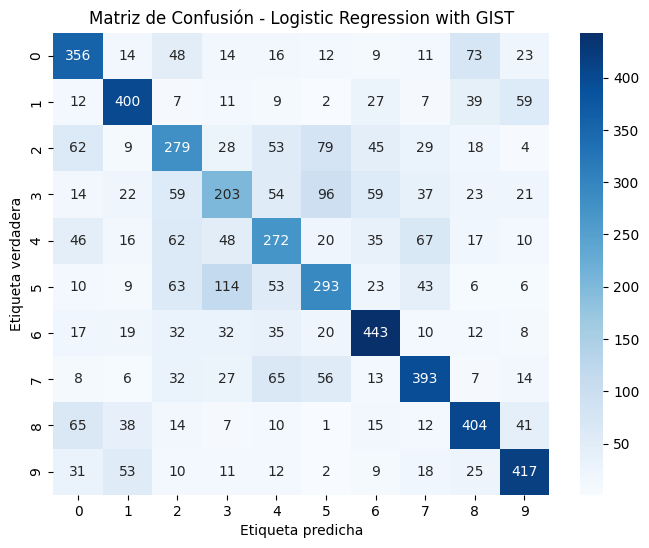

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Precisión en validación (KNN with GIST): 0.5442


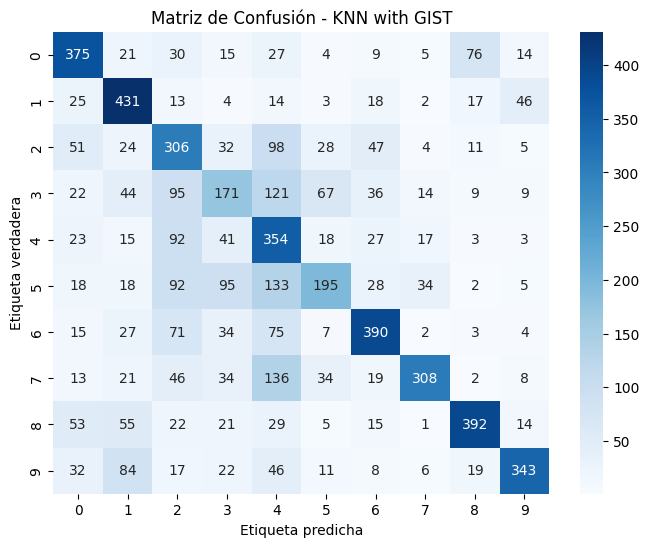

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión en validación (SVM with GIST): 0.5732


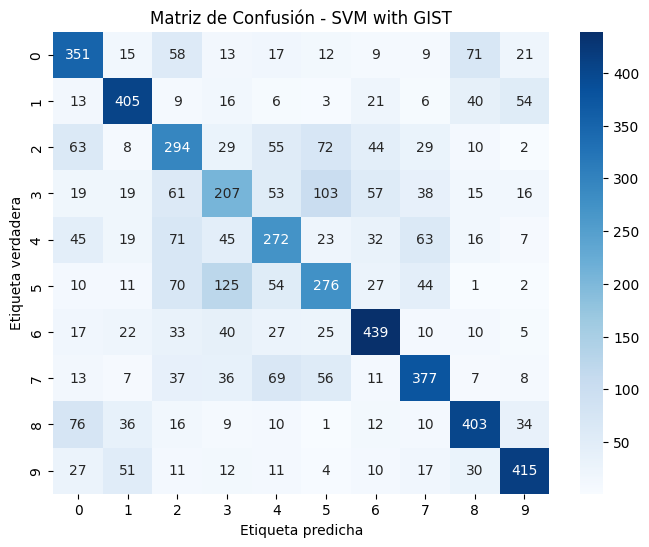

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precisión en validación (Random Forest with GIST): 0.5527


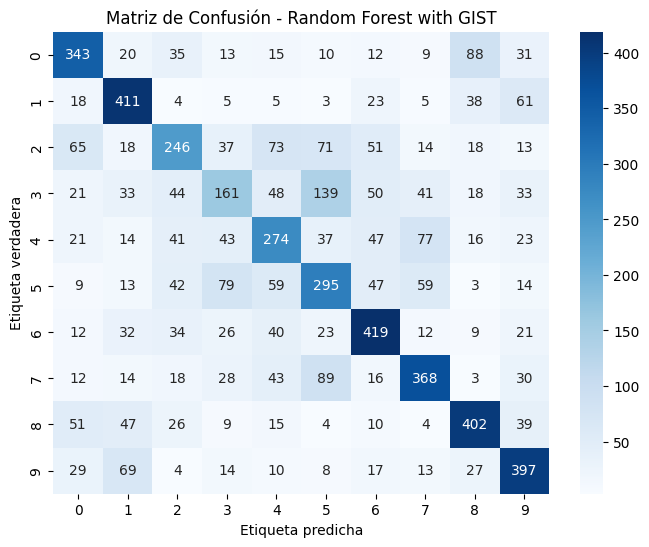

0.5526666666666666

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Train a Logistic Regression model using GIST descriptors
log_reg_gist = LogisticRegression(max_iter=500, solver='lbfgs')
train_model(log_reg_gist, 'Logistic Regression with GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

# Train a KNN model using GIST descriptors
knn_model_gist = KNeighborsClassifier(n_neighbors=3)
train_model(knn_model_gist, 'KNN(3) with GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

# Train an SVM model using GIST descriptors
svm_model_gist = SVC(kernel='linear')
train_model(svm_model_gist, 'SVM with GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

# Train a Random Forest model using GIST descriptors
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_model(rf_model, 'Random Forest with GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

#T
nb_model = GaussianNB()
train_model(nb_model, 'Naive Bayes',x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

### Logistic Regression

Precisión en validación (Logistic Regression GIST): 0.5767


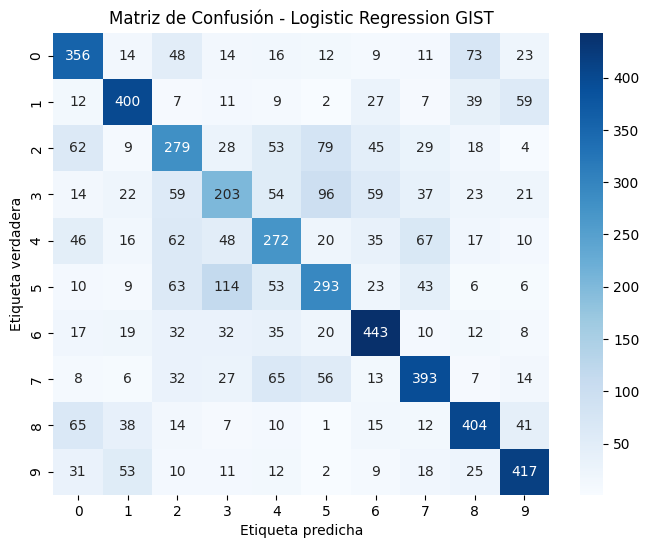

0.5766666666666667

In [ ]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
train_model(log_reg, 'Logistic Regression GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Lista de valores de n_neighbors a probar
neighbor_values = list(range(1, 31))  # Probar desde 1 hasta 20 vecinos
best_n_neighbors = None
best_val_acc = 0

# Almacenar las precisiones de cada valor de n_neighbors
val_accuracies = []

# Probar cada valor de n_neighbors
for n in neighbor_values:
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(x_train_gist_scaled, y_train)

    # Predecir en el conjunto de validación
    y_val_pred = knn_model.predict(x_val_gist_scaled)

    # Evaluar la precisión en el conjunto de validación
    val_acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_acc)

    print(f"n_neighbors = {n}, Precisión en validación: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_n_neighbors = n

print(f"\nMejor valor de n_neighbors: {best_n_neighbors} con precisión en validación: {best_val_acc:.4f}")


n_neighbors = 1, Precisión en validación: 0.5323
n_neighbors = 2, Precisión en validación: 0.5067
n_neighbors = 3, Precisión en validación: 0.5442
n_neighbors = 4, Precisión en validación: 0.5555
n_neighbors = 5, Precisión en validación: 0.5595
n_neighbors = 6, Precisión en validación: 0.5715
n_neighbors = 7, Precisión en validación: 0.5702
n_neighbors = 8, Precisión en validación: 0.5730
n_neighbors = 9, Precisión en validación: 0.5730
n_neighbors = 10, Precisión en validación: 0.5767
n_neighbors = 11, Precisión en validación: 0.5752
n_neighbors = 12, Precisión en validación: 0.5733
n_neighbors = 13, Precisión en validación: 0.5745
n_neighbors = 14, Precisión en validación: 0.5740
n_neighbors = 15, Precisión en validación: 0.5757
n_neighbors = 16, Precisión en validación: 0.5765
n_neighbors = 17, Precisión en validación: 0.5713
n_neighbors = 18, Precisión en validación: 0.5742
n_neighbors = 19, Precisión en validación: 0.5755
n_neighbors = 20, Precisión en validación: 0.5773
n_neighbo

Precisión en validación (KNN GIST): 0.5773


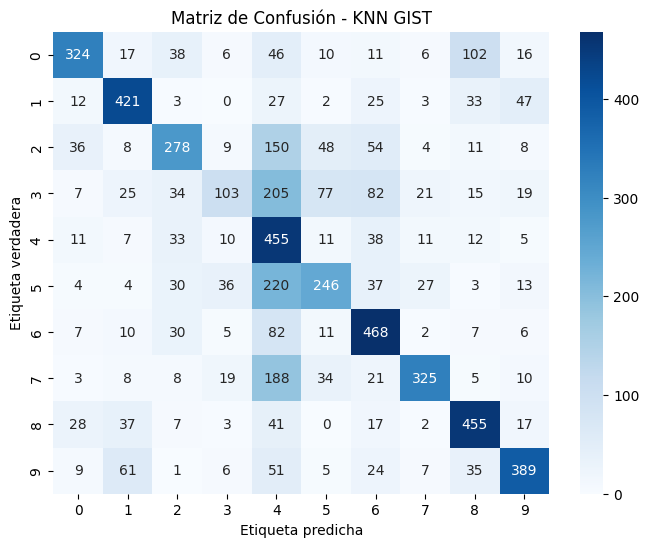

0.5773333333333334

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=20)
train_model(knn_model, 'KNN GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

### SVC

Precisión en validación (SVM (linear) GIST): 0.5732


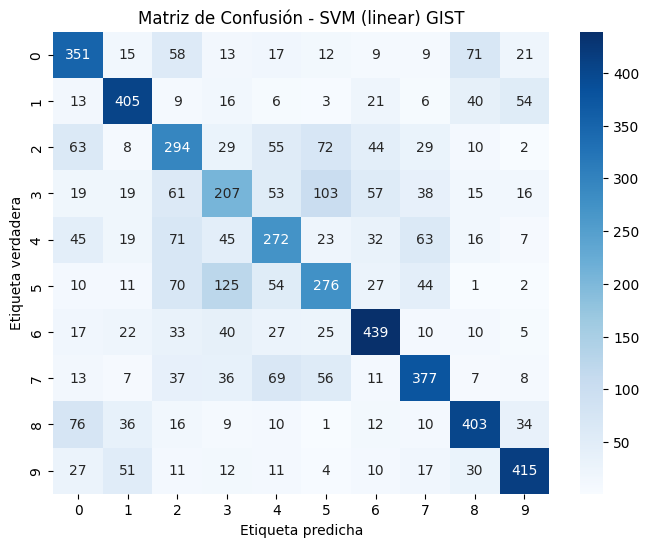

In [ ]:
from sklearn.svm import SVC

svm_model_lineal = SVC(kernel='linear')
accuracy, svm_model_lineal = train_model(svm_model_lineal, 'SVM (linear) GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

Precisión en validación (SVM (rbf) GIST): 0.6815


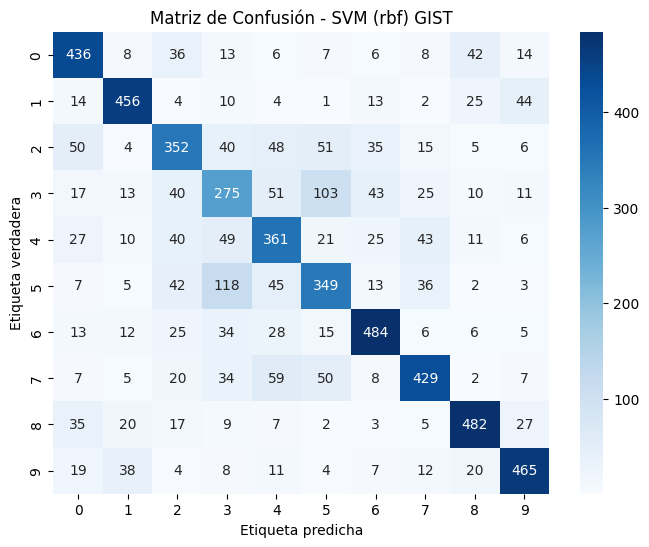

In [ ]:
from sklearn.svm import SVC

svm_model_rbf = SVC(kernel='rbf')
accuracy, svm_model_rbf= train_model(svm_model_rbf, 'SVM (rbf) GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)


### Decision Trees

Precisión en validación (Decision Tree Classifier GIST): 0.3278


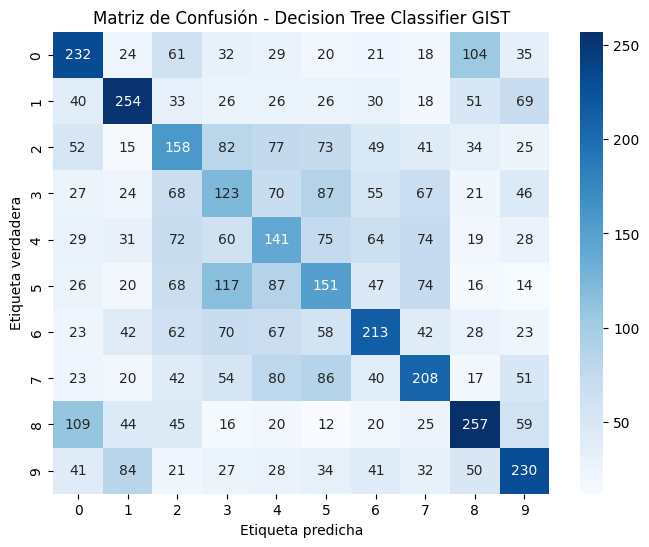

0.3278333333333333

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
train_model(tree_model, 'Decision Tree Classifier GIST', x_train_gist_scaled, y_train, x_val_gist_scaled, y_val)

### Naive Bayes

Precisión en validación (Naive Bayes GIST): 0.3077


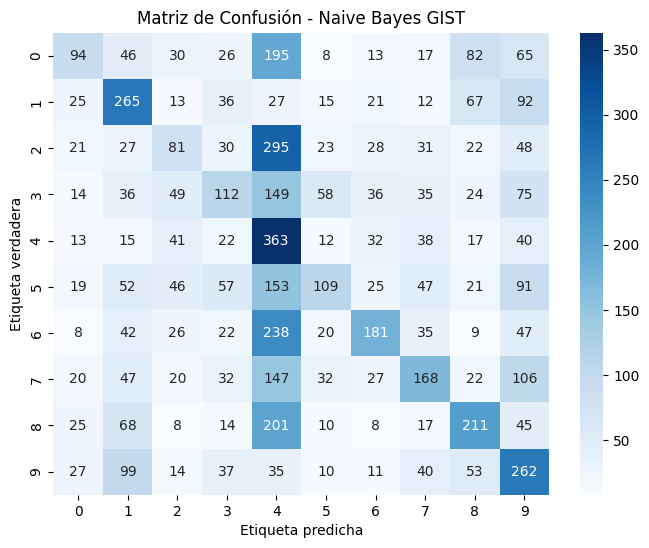

0.30766666666666664

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
train_model(nb_model, 'Naive Bayes GIST', x_train_pca, y_train, x_val_pca, y_val)

## Final Evaluation

Precisión en Test: 0.5378


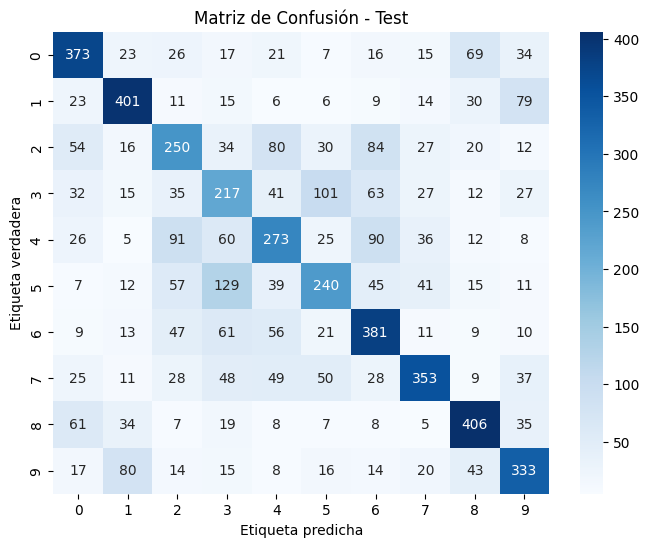

In [ ]:
# Evaluate the best model on the test set
best_model = svm_model_rbf_pca
y_test_pred = best_model.predict(x_test_pca)

test_acc = accuracy_score(y_test, y_test_pred)
print(f'Precisión en Test: {test_acc:.4f}')
plot_confusion_matrix(y_test, y_test_pred, 'Test')

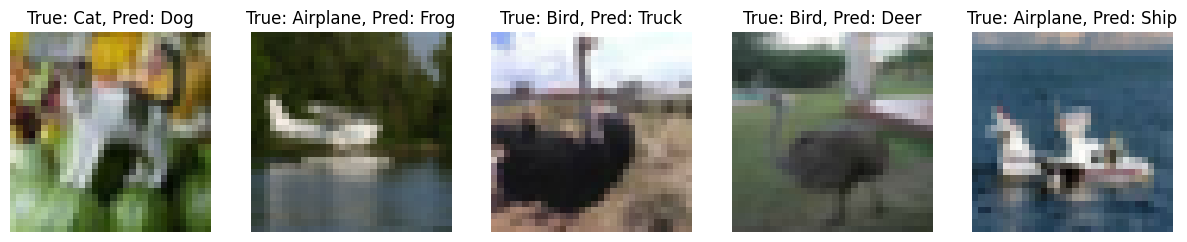

Número total de predicciones incorrectas: 2773


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de clases de CIFAR-10
cifar10_classes = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

# Obtener los índices de las predicciones incorrectas
incorrect_predictions = np.where(y_test != y_test_pred)[0]

# Mostrar algunas imágenes mal predichas (máximo 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    if i < len(incorrect_predictions):
        idx = incorrect_predictions[i]
        ax.imshow(x_test[idx])  # Mostrar la imagen original
        true_label = cifar10_classes[y_test[idx]]  # Etiqueta verdadera
        pred_label = cifar10_classes[y_test_pred[idx]]  # Etiqueta predicha
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')  # Mostrar la clase
        ax.axis('off')
    else:
        ax.axis('off')  # Si hay menos de 5 imágenes mal predichas
plt.show()

# Mostrar el número de predicciones incorrectas
num_incorrect = len(incorrect_predictions)
print(f'Número total de predicciones incorrectas: {num_incorrect}')


## Final Evaluation GIST

Precisión en Test: 0.6903


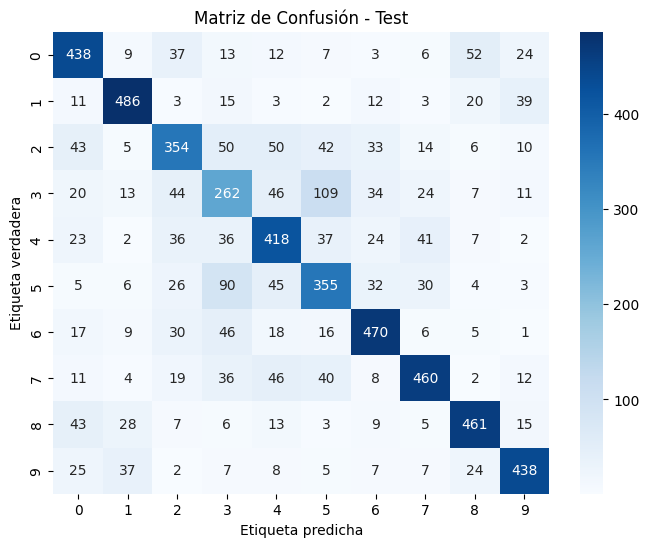

In [ ]:
# Evaluate the best model on the test set
best_model = svm_model_rbf
y_test_pred = best_model.predict(x_test_gist_scaled)

test_acc = accuracy_score(y_test, y_test_pred)
print(f'Precisión en Test: {test_acc:.4f}')
plot_confusion_matrix(y_test, y_test_pred, 'Test')

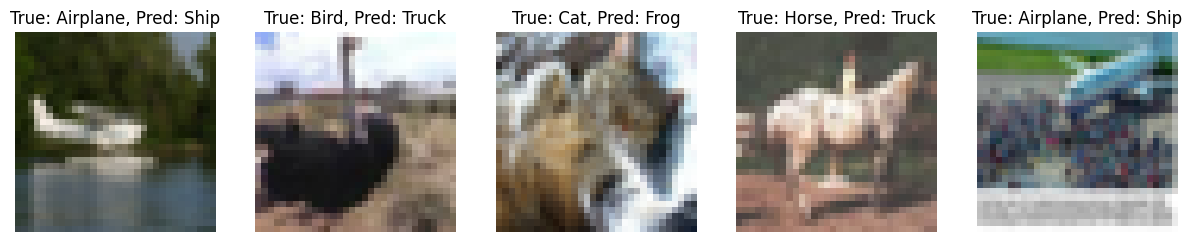

Número total de predicciones incorrectas: 1858/6000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de clases de CIFAR-10
cifar10_classes = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

# Obtener los índices de las predicciones incorrectas
incorrect_predictions = np.where(y_test != y_test_pred)[0]

# Mostrar algunas imágenes mal predichas (máximo 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    if i < len(incorrect_predictions):
        idx = incorrect_predictions[i]
        ax.imshow(x_test[idx])  # Mostrar la imagen original
        true_label = cifar10_classes[y_test[idx]]  # Etiqueta verdadera
        pred_label = cifar10_classes[y_test_pred[idx]]  # Etiqueta predicha
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')  # Mostrar la clase
        ax.axis('off')
    else:
        ax.axis('off')  # Si hay menos de 5 imágenes mal predichas
plt.show()

# Mostrar el número de predicciones incorrectas
num_incorrect = len(incorrect_predictions)
print(f'Número total de predicciones incorrectas: {num_incorrect}/{len(y_test)}')
